In [2]:
import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
import scipy.fftpack as fftp
import os
from scipy import signal
import scipy
import matplotlib.pyplot as plt
import time
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
%pylab inline

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


## Retrieve Transfer Function and all geophone/tip data

In [2]:
figsize(15,6)
[transf_Alb, freqs_Alb] = joblib.load('Albert_Data/2019-02-26/trx2_v2')
print('2',end='\r')
folder_loc = 'Albert_Data/2019-01-28/'
file_loc = '2019-01-28-geophone-scan'
dat1 = np.loadtxt(folder_loc+file_loc+'001'+'.dat',skiprows=137)

for j in arange(2,365):
    file = folder_loc+file_loc+str(j).zfill(3)+'.dat'
    try:
        temp_dat = np.loadtxt(file, skiprows=137)
        dat1 = np.concatenate((dat1,temp_dat))
        print(j,end='\r')
    except:
        pass

print('Scan file loaded')

Scan file loaded


In [3]:
folder_loc = 'Albert_Data/2019-02-21/'
file_loc = 'fast-transfer-function-'
dat2 = np.loadtxt(folder_loc+file_loc+'001'+'.dat',skiprows=6)

for j in arange(2,1000):
    file = folder_loc+file_loc+str(j).zfill(3)+'.dat'
    try:
        temp_dat = np.loadtxt(file, skiprows=6)
        dat2 = np.concatenate((dat2,temp_dat))
        print(j,end='\r')
    except:
        pass
print('Long geophone and tip file loaded, dat2')


Long geophone and tip file loaded, dat2


In [3]:
folder_loc = 'Albert_Data/2019-02-25/'
file_loc = 'noisy_cur_10khz-'
dat3 = np.loadtxt(folder_loc+file_loc+'001'+'.dat',skiprows=6)

for j in arange(2,82):
    file = folder_loc+file_loc+str(j).zfill(3)+'.dat'
    try:
        temp_dat = np.loadtxt(file, skiprows=6)
        dat3 = np.concatenate((dat3,temp_dat))
        print(j,end='\r')
    except:
        pass
print('Driven data loaded')


Driven data loaded


In [21]:
folder_loc = 'Albert_Data/2019-02-26/'
file_loc = 'topo_2-'
dat4 = np.loadtxt(folder_loc+file_loc+'001'+'.dat',skiprows=6)

for j in arange(2,132):
    file = folder_loc+file_loc+str(j).zfill(3)+'.dat'
    try:
        temp_dat = np.loadtxt(file, skiprows=6)
        dat4 = np.concatenate((dat4,temp_dat))
        print(j,end='\r')
    except:
        pass
print('Topographical file loaded')


Topographical file loaded


In [4]:
#Function finds the reshape value of the data to get closest to the desired frequency resolution
def res(freq_res, data_length, fs = 10000):
    # freq_res: desired frequency resolution
    # data_length: length of the data being transformed
    # fs: sampling rate that data was collected at (default=10000)
    #  Output:
    # Cuts: value that data can be reshaped as to reach desired resolution  
    cuts = int((data_length*freq_res)/fs)
    data_end = data_length%cuts
    return cuts,data_end
figsize(15,6)
resolution = 0.1
# len1 = len(dat1[:,0])
# len2 = len(dat2[:,0])
# len3 = len(dat3[:,0])
len4 = len(dat4[:,0])
# cuts1,end1 = res(resolution,len1)
# cuts2,end2 = res(resolution,len2)
# cuts3,end3 = res(resolution,len3)
cuts4,end4 = res(resolution,len4)

## Create variable arrays
#### Geophone

In [22]:
# geo_scanned = dat1[:-end1,1].reshape(cuts1,-1)
# geo_transfer = dat2[:-end2,0].reshape(cuts2,-1)
# geo_noisy = dat3[:,2]#.reshape(cuts3,-1)
# geo_topo = dat4[:-end4,0].reshape(cuts4,-1)
geo_topo = dat4[:,0]
# t = linspace(0,int(len(dat1[:1000000,1])/10000),len(dat1[:1000000,1]))
# plot(t,dat1[:1000000,1]-mean(dat1[:1000000,1]))
# xlim(0,10)
# title("Real Geophone Data")
# print(len(geo_scanned[1,:])/10000)

#### Tip

In [23]:
# tip_scanned = dat1[:-end1,6].reshape(cuts1,-1)
# tip_transfer = dat2[:-end2,1].reshape(cuts2,-1)
# tip_noisy = dat3[:,6].reshape(cuts3,-1)
# tip_topo = dat4[:-end4,3].reshape(cuts4,-1)
tip_topo = dat4[:,3]
# plot(dat1[:1000000,6])
# print(cuts3)
# xlim(0,100000)

(0, 60)

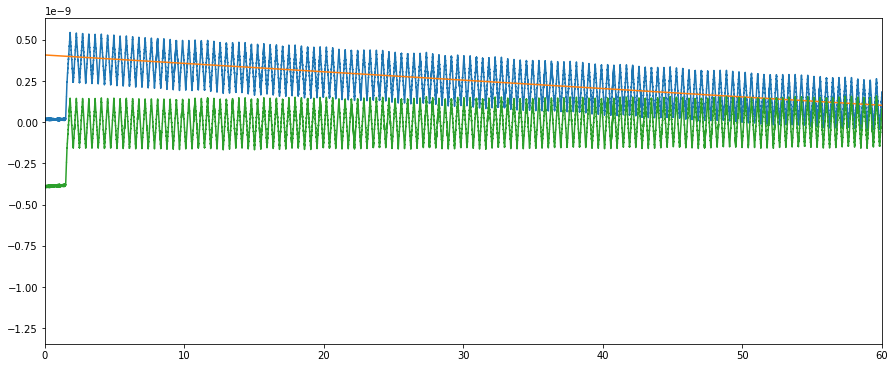

In [53]:
t= linspace(0,len(tip_topo)/10000,len(tip_topo))
plot(t,tip_topo)
fit = np.polyfit(t,tip_topo,1)
p = poly1d(fit)
plot(t,p(t))

plot(t,tip_topo-p(t))
tip_fit = tip_topo-p(t)
xlim(0,60)

In [57]:
[transf_Alb, freqs_Alb] = joblib.load('Albert_Data/2019-02-26/trx_2')

transf = transf_Alb
freqs = freqs_Alb


3265200


(-1e-11, 1e-11)

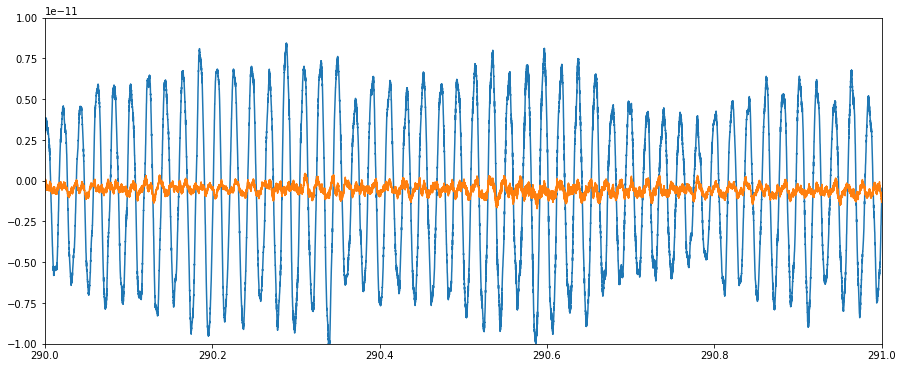

In [90]:
def create_drive(zdata, dt2, tf, freqs):
    fbottom2 = np.fft.fft(zdata)
    freq2 = np.fft.fftfreq(len(zdata),dt2)
    freq2[freq2 > freqs[np.argmax(freqs)]] = freqs[np.argmax(freqs)]
    freq2[freq2 < freqs[np.argmin(freqs)]] = freqs[np.argmin(freqs)]
    
    driver = np.fft.ifft(tf(freq2)*fbottom2)
    return driver
print(len(geo_topo))
nc = cancel.Cancel(geo_topo[:2500000],tip_fit[:2500000],(1/10000),p=[200000,125000,5])
cancelled = tip_topo[2500000:]-create_drive(geo_topo[2500000:],1/10000,transf,freqs)
plot(t[2500000:],tip_topo[2500000:]+1.1925e-9)
plot(t[2500000:],cancelled+1.1925e-9)
xlim(290,291)
ylim(-0.1e-10,0.1e-10)

#### Current

In [8]:
# cur_scanned = dat1[:-end1,0].reshape(cuts1,-1)
cur_noisy = dat3[:,0]#.reshape(cuts3,-1)
# plot(dat1[:100000,0])

In [10]:
nc = cancel.Cancel(geo_noisy,tip_noisy,(1/10000),p=[50000,10000,5])

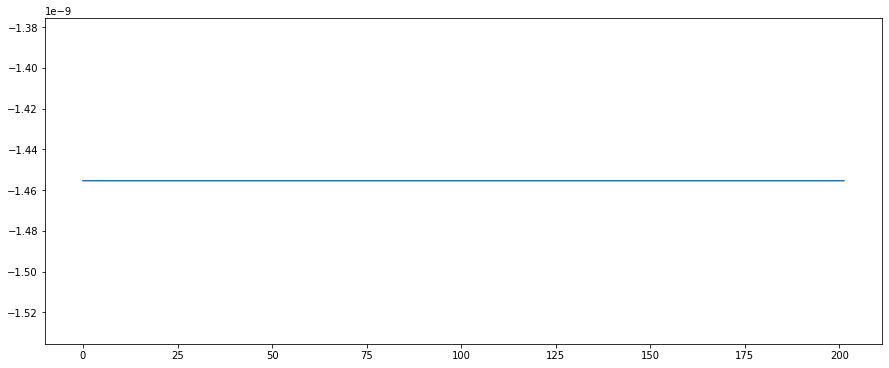

In [20]:
t= linspace(0,len(cur_noisy)/10000,len(cur_noisy))
plot(t,tip_noisy)
# plot(t,tip_noisy-nc.create_drive(geo_noisy))
canc = (sqrt(mean((tip_noisy-nc.create_drive(geo_noisy))**2)))
reg = (sqrt(mean(tip_noisy**2)))
# xlim(0,1)

#### LIY

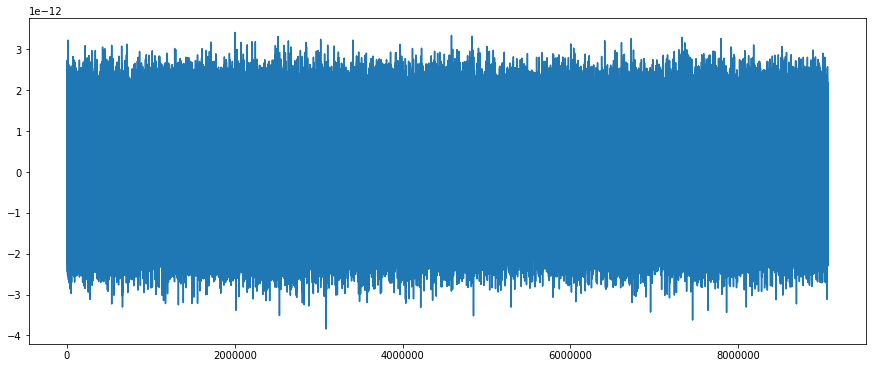

In [10]:
LIY_scanned = dat1[:-end1,8].reshape(cuts1,-1)
LIY_noisy = dat3[:,8].reshape(cuts3,-1)
plot(dat1[:,8])

## Average Frequency Domains

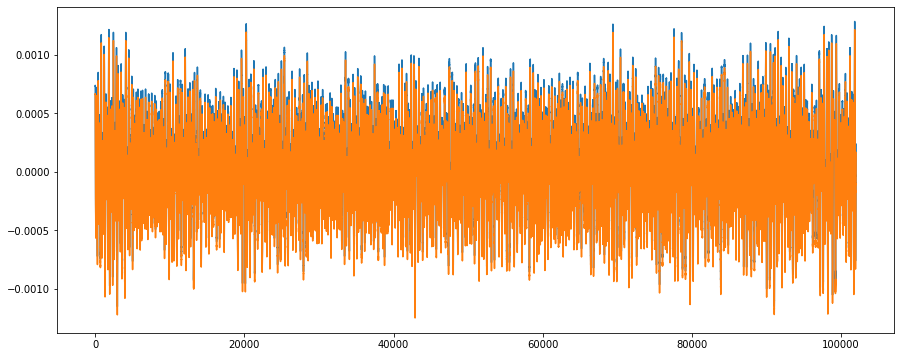

In [11]:
def array_avg(array):
    avg_vals = mean(array,axis=1)
    temp_array = np.zeros(shape(array))
    for i in arange(len(avg_vals)):
        temp_array[i,:] = array[i,:]-avg_vals[i]
    return(temp_array)
# Subtract mean and divide by range.
def normalize2(array):
    return (array-mean(array))/(max(array) - min(array))
plot(geo_topo[2])
plot(geo_topo[2]-mean(geo_topo[2]))

Text(0.5, 1.0, 'Real Geophone Frequency Response')

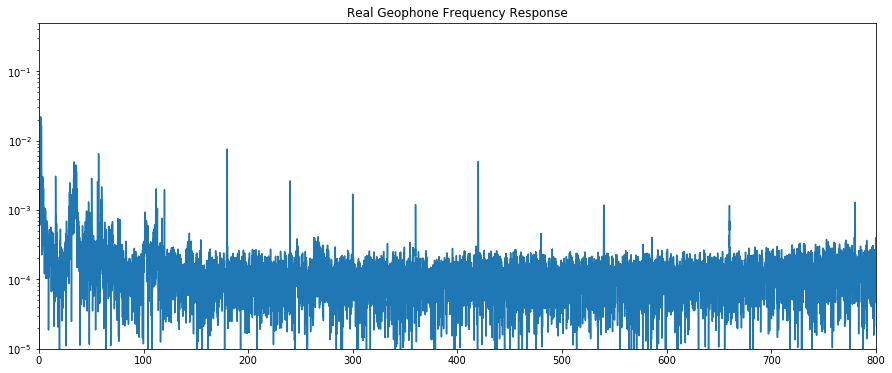

In [12]:


geo_fft_scanned = mean(fft.fft(array_avg(geo_scanned)),axis=0)
geo_fft_transfer = mean(fft.fft(array_avg(geo_transfer)),axis=0)
geo_fft_noisy = mean(fft.fft(array_avg(geo_noisy)),axis=0)
geo_fft_topo = mean(fft.fft(array_avg(geo_topo)),axis=0)
freq = fft.fftfreq(len(geo_fft_transfer),1/10000)
semilogy(freq[:int(len(freq)/2)],(abs(geo_fft_transfer[:int(len(freq)/2)])))
xlim(0,800)
ylim(0.00001,0.5)
# ylim(1e-5,1)
title("Real Geophone Frequency Response")

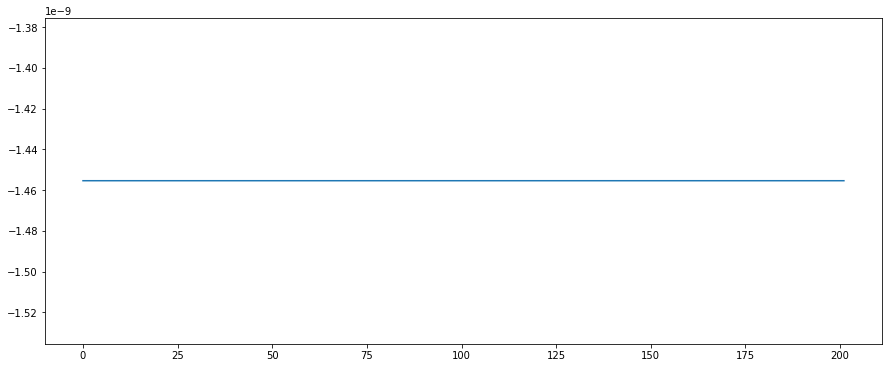

In [13]:
t = linspace(0,int(len(dat3[:,6])/10000),len(dat3[:,6]))
plot(t,dat3[:,6])
# xlim(0,100)

In [14]:
tip_fft_scanned = mean(fft.fft(array_avg(tip_scanned)),axis=0)
tip_fft_transfer = mean(fft.fft(array_avg(tip_transfer)),axis=0)
tip_fft_noisy = mean(fft.fft(array_avg(tip_noisy)),axis=0)
tip_fft_topo = mean(fft.fft(array_avg(tip_topo)),axis=0)

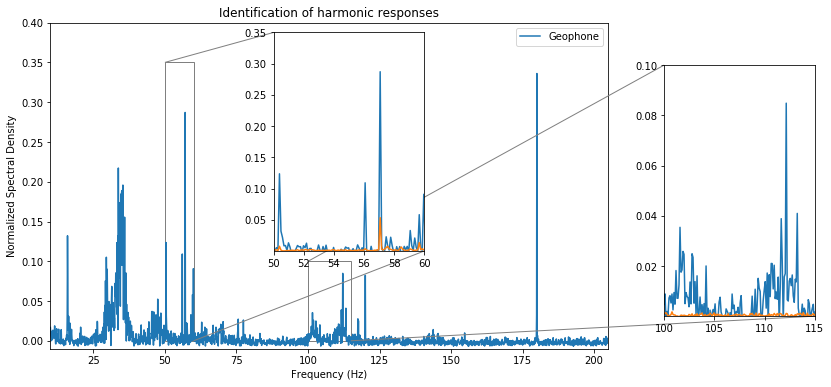

In [15]:
figsize(10,6)
freq = fft.fftfreq(len(tip_fft_transfer),1/10000)
fig, ax = plt.subplots() # create a new figure with a default 111 subplot
ax.plot(freq[:int(len(freq)/2)],normalize2(abs(geo_fft_transfer[:int(len(freq)/2)])),label='Geophone')
# ax.plot(freq[:int(len(freq)/2)],0.2*normalize2(abs(tip_fft_transfer[:int(len(freq)/2)])),label='Tip')

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
axins= ax.inset_axes([1.1, 0.1, 0.27, 0.77])
# axins = zoomed_inset_axes(ax, 2.5, loc=1) # zoom-factor: 2.5
axins.plot(freq[:int(len(freq)/2)],normalize2(abs(geo_fft_transfer[:int(len(freq)/2)])))
axins.plot(freq[:int(len(freq)/2)],0.2*normalize2(abs(tip_fft_transfer[:int(len(freq)/2)])))

x1, x2, y1, y2 = 100, 115, 0.0001, 0.1 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits


axins2= ax.inset_axes([0.4, 0.3, 0.27, 0.67])
# axins2 = zoomed_inset_axes(ax, 2.5, loc=9) # zoom-factor: 2.5
axins2.plot(freq[:int(len(freq)/2)],normalize2(abs(geo_fft_transfer[:int(len(freq)/2)])))
axins2.plot(freq[:int(len(freq)/2)],0.2*normalize2(abs(tip_fft_transfer[:int(len(freq)/2)])))
x1, x2, y1, y2 = 50, 60, 0.000001, 0.35 # specify the limits
axins2.set_xlim(x1, x2) # apply the x-limits
axins2.set_ylim(y1, y2) # apply the y-limits

# plt.yticks(visible=False)
# axins2.set_yticklabels('')
# plt.xticks(visible=False)

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axins, loc1=4, loc2=2, fc="none", ec="0.5")
mark_inset(ax, axins2, loc1=4, loc2=2, fc="none", ec="0.5")

ax.set_title('Identification of harmonic responses')
ax.set_xlim(10,205)
ax.set_ylim(-0.01,0.4)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Normalized Spectral Density')
ax.legend()

In [16]:
cur_fft_scanned = mean(fft.fft(array_avg(cur_scanned)),axis=0)
cur_fft_noisy = mean(fft.fft(array_avg(cur_noisy)),axis=0)

In [17]:
LIY_fft_scanned = mean(fft.fft(array_avg(LIY_scanned)),axis=0)
LIY_fft_noisy = mean(fft.fft(array_avg(LIY_noisy)),axis=0)

In [18]:
def normalize2(array):
    return (array-mean(array))/(max(array) - min(array))

## Examination of FFT

#### Comparison of unaveraged FFT and averaged FFT (with frequency resolution of 0.1 Hz)

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


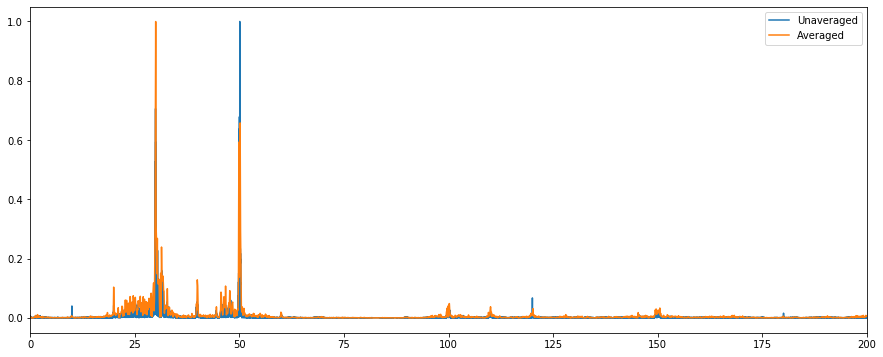

In [19]:
figsize(15,6)
unaveraged_geo_fft = fft.fft(dat3[:,2]-mean(dat3[:,2]))
freqs_UA = fft.fftfreq(len(unaveraged_geo_fft),1/10000)
freqs = fft.fftfreq(len(geo_fft_noisy),1/10000)
plot(freqs_UA[:int(len(freqs_UA)/2)],normalize2(absolute(unaveraged_geo_fft[:int(len(freqs_UA)/2)])),label='Unaveraged')
plot(freqs[:int(len(freqs)/2)],normalize2(absolute(geo_fft_noisy[:int(len(freqs)/2)])),label='Averaged')
xlim(0,200)

legend()

#### Geophone and Tip comparison

[49.69684922 49.79624292 49.89563662 49.99503032 50.09442401 50.19381771
 50.29321141 50.39260511 50.49199881 50.59139251 50.6907862  50.7901799
 50.8895736  50.9889673  51.088361   51.1877547  51.28714839 51.38654209
 51.48593579 51.58532949 51.68472319 51.78411689 51.88351059 51.98290428
 52.08229798 52.18169168 52.28108538 52.38047908 52.47987278 52.57926647]
[3.51610657e-09 3.69421163e-08 1.58916579e-07 3.90835157e-08
 1.29668810e-07 1.69173664e-07 6.47351395e-08 3.64684470e-08
 9.45715806e-09 4.58374139e-09 7.77328668e-09 3.96093271e-09
 3.12834483e-09 2.81934038e-09 7.68902583e-09 3.07209650e-09
 3.80217679e-09 2.37165708e-09 9.41249995e-10 5.18877572e-10
 1.18243805e-09 1.34643932e-09 1.49348077e-09 2.34448988e-09
 1.88921617e-09 2.87085526e-09 2.40834218e-10 5.60474361e-09
 3.93155742e-09 3.00728414e-09]
1.6917366386648927e-07 2.3827639802086753e-08
0.1408472173357395


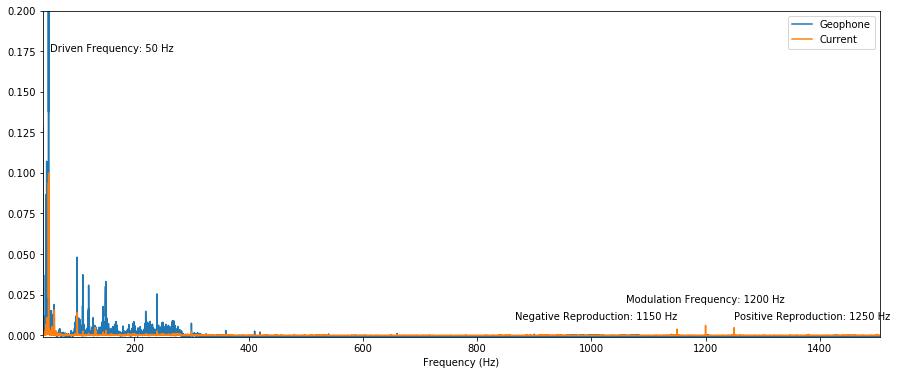

In [30]:
figsize(15,6)
freqs = fft.fftfreq(len(geo_fft_noisy),1/10000)
fundamental = 3.18059835
harmonics = [int(fundamental/freqs[1]),int(fundamental*2/freqs[1]),int(fundamental*3/freqs[1]),
             int(fundamental*4/freqs[1]),int(fundamental*5/freqs[1]),int(fundamental*6/freqs[1])]
plot(freqs[0:int(len(freqs)/2)],normalize2(absolute(geo_fft_noisy[0:int(len(freqs)/2)])),label='Geophone')
plot(freqs[0:int(len(freqs)/2)],0.1*normalize2(absolute(cur_fft_noisy[0:int(len(freqs)/2)])),label='Current')
# plot(freqs[harmonics],normalize2(absolute(tip_fft_scanned[harmonics])),'.')
print(freqs[500:530])
# print(absolute(geo_fft_noisy[1000:1030]))
print(absolute(cur_fft_noisy[500:530]))
# print(mean(abs(geo_fft_noisy)),mean(abs(tip_fft_noisy)))
print(max(absolute(cur_fft_noisy[490:560])),max(absolute(cur_fft_noisy[1000:1030])))
print(max(absolute(cur_fft_noisy[1000:1030]))/max(absolute(cur_fft_noisy[490:560])))
plt.text(52,0.175,'Driven Frequency: 50 Hz',ha='left')
plt.text(1150.2,0.01,'Negative Reproduction: 1150 Hz',ha='right')
plt.text(1250,0.01,'Positive Reproduction: 1250 Hz',ha='left')
plt.text(1200,0.02,'Modulation Frequency: 1200 Hz',ha='center')
# xlim(0,5000)
xlim(40,1505)
ylim(-0.001,0.2)
xlabel('Frequency (Hz)')
# title('Harmonic presence in noisy current data')
legend()

In [21]:
transf = cur_fft_noisy/geo_fft_noisy
print(len)
# plot(freqs[0:int(len(freqs)/2)],absolute(transf[0:int(len(freqs)/2)]),label='Geophone')


<built-in function len>


10.0227


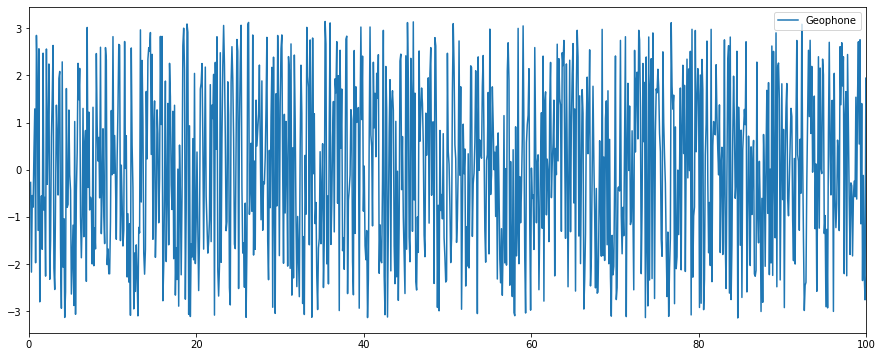

In [33]:
tip_fft_transfer[0:10] = 0+0j
plot(freqs[2:int(len(freqs)/2)],(angle(geo_fft_transfer[2:int(len(freqs)/2)])),label='Geophone')
# loglog(freqs[:int(len(freqs)/2)],(absolute(tip_fft_transfer[:int(len(freqs)/2)])),label='Tip')
print(len(tip_fft_transfer)/10000)
xlim(0,100)
# ylim(-0.1,0.1)
legend()

[ 1.04820886e-19+0.00000000e+00j -6.16912693e-09-9.04313619e-10j]
[0.+0.j 0.+0.j]
[1.66445283e-36+0.00000000e+00j 1.17176621e-37-1.97368285e-37j]


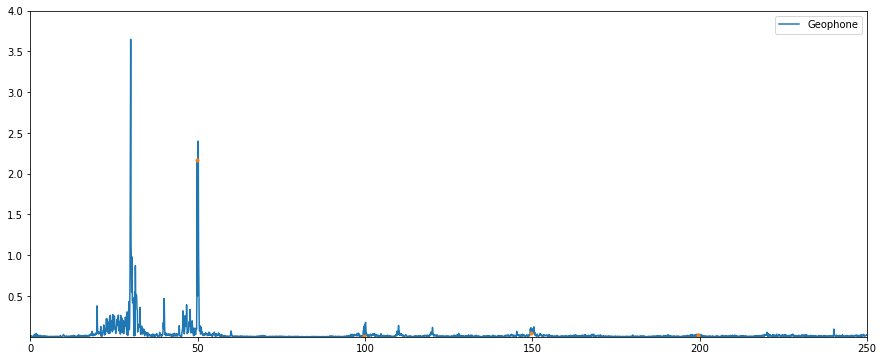

In [23]:
# Z data is constant
tip_fft_noisy[0] = (4.16113207e-20+0.00000000e+00j)*4e-17
driven = 49.9
harmonics = [int(driven/freqs[1]),int(driven*2/freqs[1]),int(driven*3/freqs[1]),int(driven*4/freqs[1])]
plot(freqs[:int(len(freqs)/2)],(absolute(geo_fft_noisy[:int(len(freqs)/2)])),label='Geophone')
plot(freqs[harmonics],absolute(geo_fft_noisy[harmonics]),'.')
# plot(freqs[:int(len(freqs)/2)],normalize2(absolute(tip_fft_noisy[:int(len(freqs)/2)])),label='Tip')
print(tip_fft_scanned[0:2])
print(tip_fft_transfer[0:2])
print(tip_fft_noisy[0:2])
xlim(0,250)
ylim(1e-5,4)
legend()

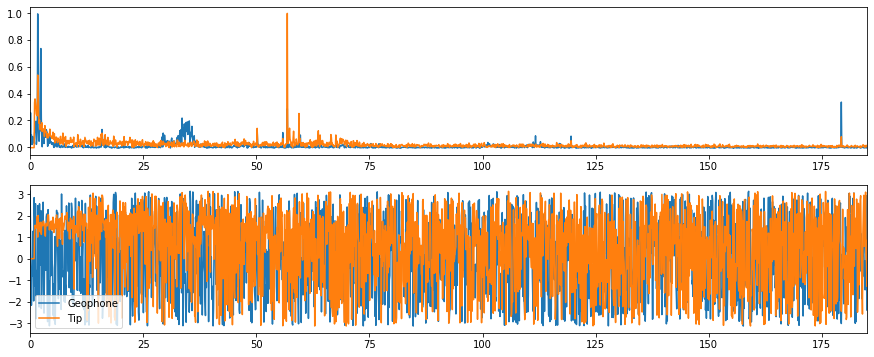

In [59]:
# tip_fft_topo[1] = (-7.36203738e-08-7.30020499e-07j)*1e-14
# tip_fft_topo[2] = (-9.41204500e-08-3.15661852e-07j)*1e-14
ax1 = plt.subplot(211)

tip_fft_topo[0:30] = 0+0j
plot(freqs[:int(len(freqs)/2)],normalize2(absolute(geo_fft_transfer[:int(len(freqs)/2)])),label='Geophone')
plot(freqs[:int(len(freqs)/2)],normalize2(absolute(tip_fft_transfer[:int(len(freqs)/2)])),label='Tip')
ax2 = plt.subplot(212, sharex=ax1)
plot(freqs[:int(len(freqs)/2)],(angle(geo_fft_transfer[:int(len(freqs)/2)])),label='Geophone')
plot(freqs[:int(len(freqs)/2)],(angle(tip_fft_transfer[:int(len(freqs)/2)])),label='Tip')
xlim(0,185)
# ylim(0,0.01)
# print(tip_fft_topo[0:5])
legend()

In [25]:
x1 = np.arange(12.0).reshape((4, 3))
x2 = np.arange(3.0)
print(x1)
print(x2)
print(np.subtract(x1, x2))
print(shape(x1),shape(x2))


[[ 0.  1.  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]
 [ 9. 10. 11.]]
[0. 1. 2.]
[[0. 0. 0.]
 [3. 3. 3.]
 [6. 6. 6.]
 [9. 9. 9.]]
(4, 3) (3,)


(0, 0.1)

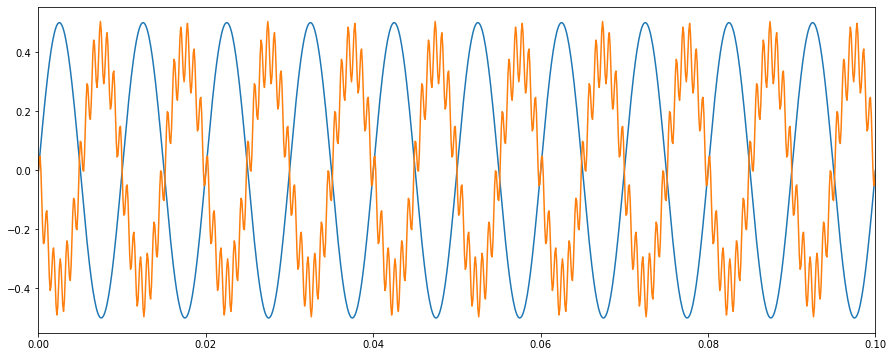

In [26]:
figsize(15,6)
t = linspace(0,100,1000000)
wave = np.sin(100*2*np.pi*t)# + 0.5*np.sin(200*2*np.pi*t)+ 0.3333*np.sin(300*2*np.pi*t)  

I_0 = 200e-6
v_dc = np.zeros(len(t))
v_mod = 1250
mod_amp = 1e-6
v_dc = v_dc + I_0
I = v_dc + mod_amp*sin(2*np.pi*v_mod*t)

kappa = 2e-2

cur = I*exp(-kappa*wave)

plot(t,normalize2(wave))
plot(t,normalize2(cur-mean(cur)))

xlim(0,0.1)

(40, 1555)

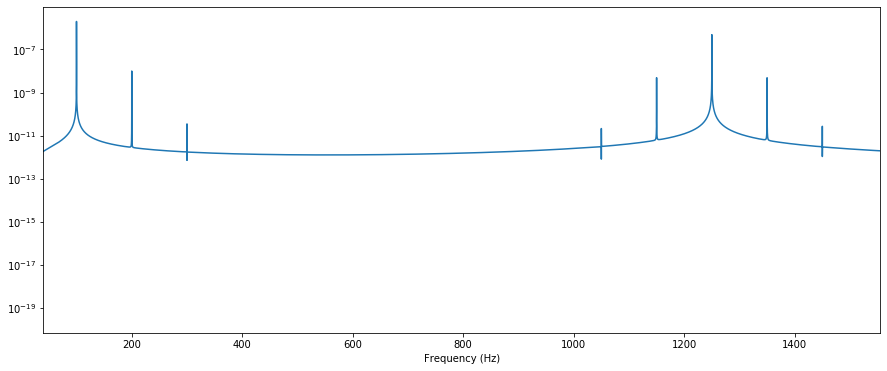

In [27]:
figsize(15,6)
freq = np.fft.fftfreq(len(cur),1/10000)
synth_cur = np.fft.fft(cur-mean(cur))/len(cur)
log_cur = np.log10(cur)
log_synth_cur = np.fft.fft(log_cur-mean(log_cur))/len(cur)
semilogy(freq[:int(len(freq)/2)],abs(synth_cur[:int(len(freq)/2)]))
# semilogy(freq[:int(len(freq)/2)],abs(log_synth_cur[:int(len(freq)/2)]))
# title('Harmonic appearance of exponentiated waveform')
xlabel('Frequency (Hz)')
xlim(40,1555)
# ylim(1e-9,1e-1)
# val = abs(synth_cur[5000])
# for a in arange(10):
#     print(abs(synth_cur[5000*(a+1)]),(abs(synth_cur[5000*(a+1)]))/val)
# ylim(-0.0000001,0.00000001)

### I have fixed spectroscopic aliasing

NameError: name 'wave_after_fft' is not defined

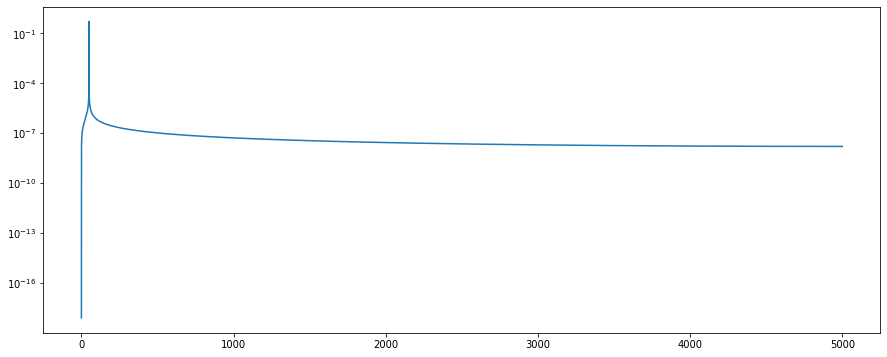

In [28]:
figsize(15,6)
t = linspace(0,100,1000000)
wave = np.sin(50*2*np.pi*t) #+ 0.5*np.sin(200*2*np.pi*t)+ 0.3333*np.sin(300*2*np.pi*t)  
wave_after = wave*0.01
I_0 = 200e-6
v_dc = np.zeros(len(t))
v_mod = 1250
mod_amp = 1e-6
v_dc = v_dc + I_0
I = v_dc + mod_amp*sin(2*np.pi*v_mod*t)

kappa = 2e-2

cur1 = I*exp(-kappa*wave)
log_cur = np.log10(cur1)

freq = np.fft.fftfreq(len(cur),1/10000)
synth_cur1 = np.fft.fft(cur1-mean(cur1))/len(cur1)
synth_log_cur = np.fft.fft(log_cur-mean(log_cur))/len(log_cur)
wave_fft = np.fft.fft(wave-mean(wave))/len(wave)

alias_cur = np.copy(wave_fft)
alias_cur[v_mod*100+1:v_mod*100*2] = 0.01*wave_fft[1:v_mod*100]
alias_cur[0:v_mod*100-1] = 0.01*np.flip(wave_fft[1:v_mod*100])
alias_cur[-v_mod*100*2:-v_mod*100-1] = 0.01*wave_fft[-v_mod*100:-1]
alias_cur[-v_mod*100+1:] = 0.01*np.flip(wave_fft[-v_mod*100:-1])

transf = (synth_cur1)/wave_fft

transf_alias = np.copy(transf)
transf_alias[v_mod*100+1:v_mod*100*2] = transf[1:v_mod*100]
transf_alias[0:v_mod*100-1] = np.flip(transf[1:v_mod*100])
transf_alias[-v_mod*100*2:-v_mod*100-1] = transf[-v_mod*100:-1]
transf_alias[-v_mod*100+1:] = np.flip(transf[-v_mod*100:-1])
# semilogy(freq[:int(len(synth_cur1)/2)],abs(transf[:int(len(synth_cur1)/2)]))
interp_vib = scipy.interpolate.interp1d(freq,transf, kind='linear')
interp_alias = scipy.interpolate.interp1d(freq,transf_alias, kind='linear')

wave_to_cur = 0.5*(wave_fft*interp_vib(freq))
# wave_to_cur[v_mod*100+1:v_mod*150] =(wave_to_cur[1:v_mod*50])
# wave_to_cur[v_mod*50:v_mod*100-1] = np.flip(wave_to_cur[1:v_mod*50])
# wave_to_cur[-v_mod*150:-v_mod*100-1] =(wave_to_cur[-v_mod*50:-1])
# wave_to_cur[-v_mod*100+1:-v_mod*50] = np.flip(wave_to_cur[-v_mod*50:-1])


# wave_cur_fft = np.fft.fft(np.exp(np.fft.ifft(wave_to_cur)))
semilogy(freq[:int(len(synth_cur1)/2)],abs(wave_fft[:int(len(synth_cur1)/2)]))
semilogy(freq[:int(len(synth_cur1)/2)],abs(wave_after_fft[:int(len(synth_cur1)/2)]))
semilogy(freq[:int(len(synth_cur1)/2)],abs(synth_cur1[:int(len(synth_cur1)/2)]))
# # semilogy(freq[:int(len(synth_cur1)/2)],abs(synth_log_cur[:int(len(synth_cur1)/2)]))
# # semilogy(freq[:int(len(synth_cur1)/2)],abs(alias_cur[:int(len(synth_cur1)/2)]))

semilogy(freq[:int(len(synth_cur1)/2)],2*abs(wave_to_cur[:int(len(synth_cur1)/2)]))
# semilogy(freq[:int(len(synth_cur1)/2)],2*abs(wave_cur_fft[:int(len(synth_cur1)/2)]))
xlim(0,1500)
# log_cur = np.log10(cur)



In [ ]:
import scipy.sparse as sps
a = sps.diags(wave_fft)
b = sps.diags(transf)
c = sps.csc_matrix(a)
d = sps.csc_matrix(b)
e = c+d
print(c)

In [ ]:
f = sps.diags(arange(10))
g = np.flip(f)
print(f)
print(g)
